In [3]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from scipy.stats import mstats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')
 

In [4]:
# Import file to notebook

sales = pd.read_csv("C:\\Users\\SYAM SELVAKUMAR\\Documents\\python projects\\WALMART_SALES_DATA.csv")

In [5]:
# To display summary of dataframe
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [6]:
# To view the first 5 values
sales.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [7]:
# To view the last 5 values
sales.tail()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667
6434,45,26-10-2012,760281.43,0,58.85,3.882,192.308899,8.667


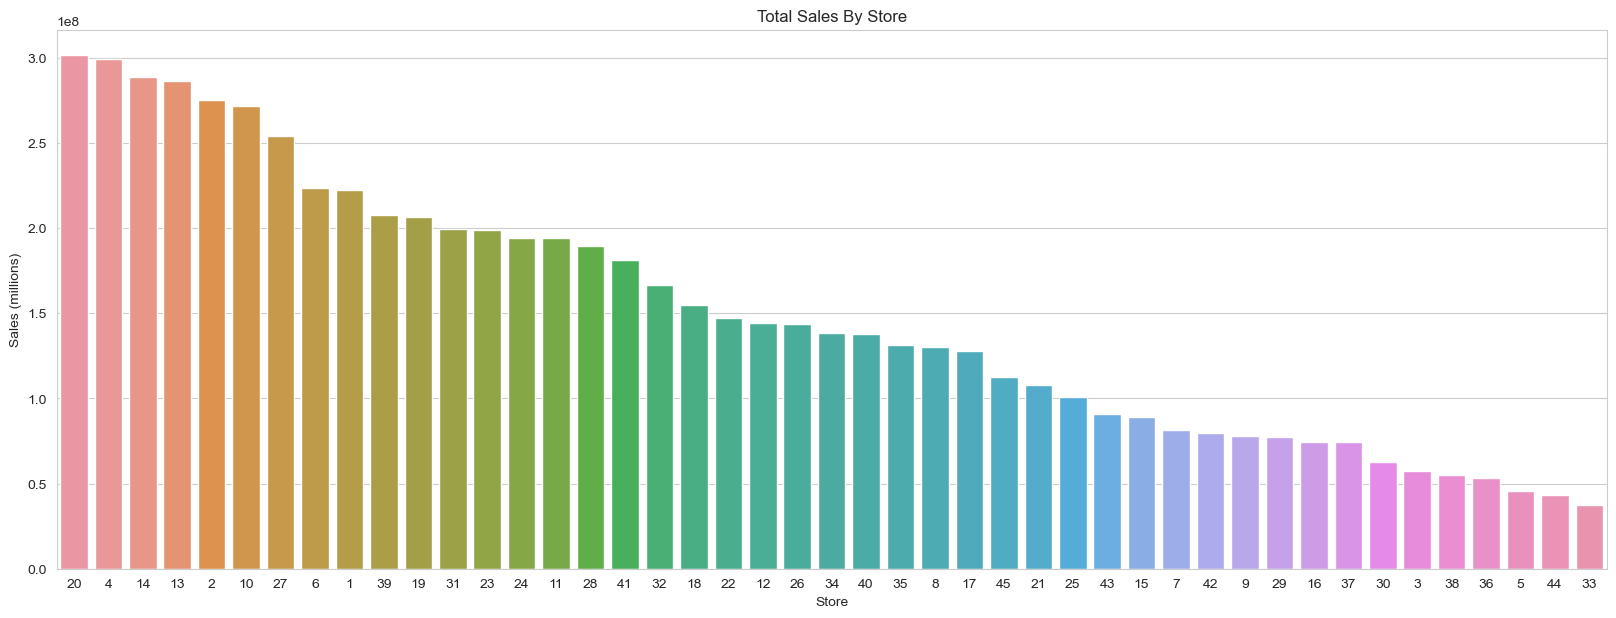

In [8]:
# To find Which store has maximum sales using bar plot?
plt.figure(figsize = (20,7))
barplot = sns.barplot(x = 'Store',
           y = 'Weekly_Sales',
           data = sales,
           estimator = np.sum,
           ci = None,
           order = sales.groupby('Store').agg('sum').reset_index().sort_values(by = 'Weekly_Sales', ascending = False)['Store']).set_title('Total Sales By Store')
plt.ylabel('Sales (millions)')
plt.show()

In [9]:
#Which stores has good quarterly growth rate in Q3’2012

# Q3 starts from July 1st to September 30th.
sales['Date'] = pd.to_datetime(sales['Date'], dayfirst = True)
Q3_2012 = sales[(sales['Date'] >= '2012-07-01') & (sales['Date'] <= '2012-09-30')]
sorted_Q3 = Q3_2012.sort_values(by = ['Store','Date'])

#Growth rate formula (Ending Value - Starting Value) / Starting Value x 100

start = sorted_Q3[sorted_Q3['Date'] == sorted_Q3['Date'].min()].reset_index()[['Store','Weekly_Sales']]
start.rename(columns = {'Weekly_Sales':'start_value'}, inplace = True)
end = sorted_Q3[sorted_Q3['Date'] == sorted_Q3['Date'].max()].reset_index()[['Store','Weekly_Sales']]
end.rename(columns = {'Weekly_Sales':'end_value'}, inplace = True)

# Top 5
growth = start.merge(end, on = 'Store')
growth['Growth%'] = round(((growth['end_value'] - growth['start_value'])/growth['start_value'])*100,2)
growth.sort_values(by = 'Growth%', ascending = False).head()

,Store,start_value,end_value,Growth%
36,37,519498.32,527953.14,1.63
43,44,358461.58,355307.94,-0.88
29,30,440553.42,425410.04,-3.44
31,32,1214183.97,1157111.15,-4.70
2,3,411206.50,389813.02,-5.20


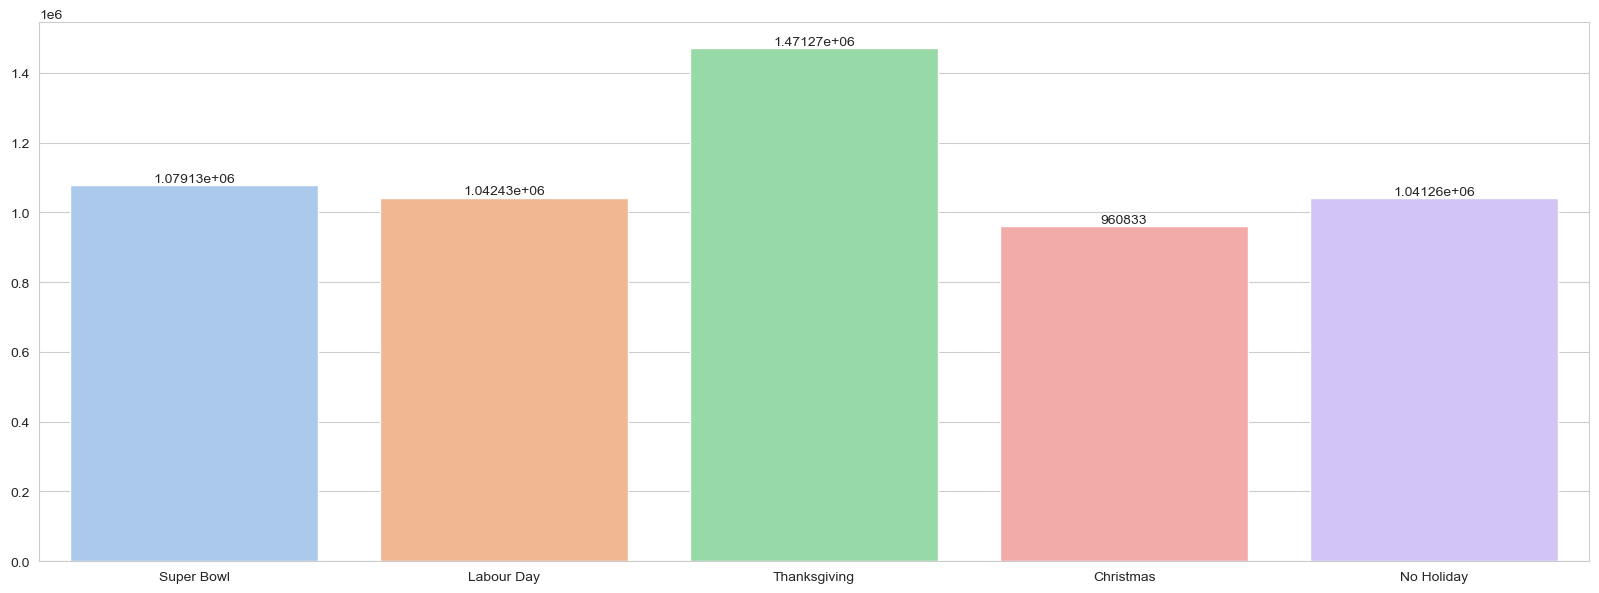

In [10]:
# Some holidays have a negative impact on sales.
# Find out holidays which have higher sales than the mean sales in non-holiday season for all stores together

#Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
#Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
#Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
#Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

super_bowl = sales[sales['Date'].isin(['2010-02-12','2011-02-11','2012-02-10'])]
labour_day = sales[sales['Date'].isin(['2010-09-10','2011-09-09','2012-09-07'])]
thanksgiving = sales[sales['Date'].isin(['2010-11-26','2011-11-25','2012-11-23'])]
christmas = sales[sales['Date'].isin(['2010-12-31','2011-12-30','2012-12-28'])]
no_holiday = sales[sales['Holiday_Flag'] == 0]

y = [super_bowl['Weekly_Sales'].mean(),
    labour_day['Weekly_Sales'].mean(),
    thanksgiving['Weekly_Sales'].mean(),
    christmas['Weekly_Sales'].mean(),
    no_holiday['Weekly_Sales'].mean()]
x = ['Super Bowl',
    'Labour Day',
    'Thanksgiving',
    'Christmas',
    'No Holiday']

plt.figure(figsize = (20,7))
barplot = sns.barplot(x = x,
           y = y,
           ci = None,
            palette = 'pastel')

barplot.bar_label(barplot.containers[0])
plt.show()

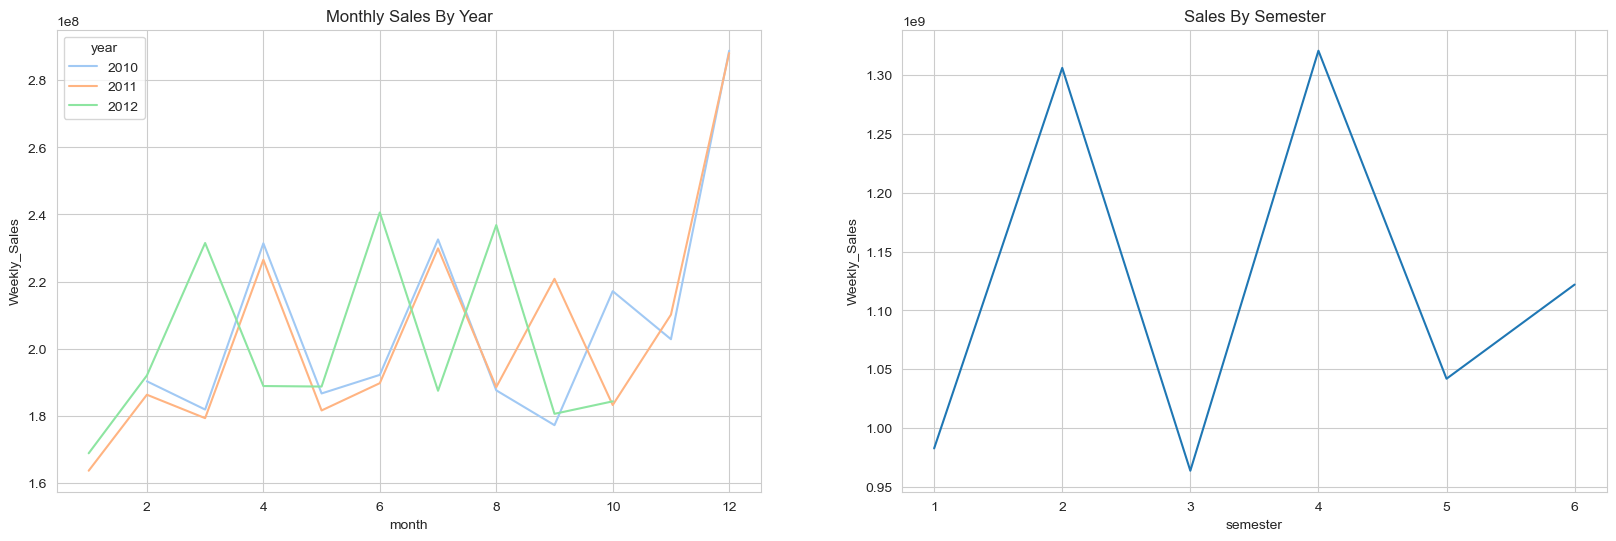

In [11]:
# Provide a monthly and semester view of sales in units and give insights

sales1 = sales.copy()
sales1['year'] = sales1['Date'].dt.year
sales1['month'] = sales1['Date'].dt.month
sales1['year_month'] = list(zip(sales1['month'],sales1['year']))

def semester(row):
    if row in [(2,2010),(3,2010),(4,2010),(5,2010),(6,2010)]:
        return 1
    elif row in [(7,2010),(8,2010),(9,2010),(10,2010),(11,2010),(12,2010)]:
        return 2
    elif row in [(2,2011),(3,2011),(4,2011),(5,2011),(6,2011)]:
        return 3
    elif row in [(7,2011),(8,2011),(9,2011),(10,2011),(11,2011),(12,2011)]:
         return 4
    elif row in [(2,2012),(3,2012),(4,2012),(5,2012),(6,2012)]:
        return 5
    else:
        return 6
    
sales1['semester'] = sales1['year_month'].apply(lambda x: semester(x))
   
fig, ax = plt.subplots(1,2, figsize = (20,6))

sns.lineplot(x = 'month', y = 'Weekly_Sales',
             hue = 'year',
            data = sales1,
            ci = None,
            estimator = np.sum,
             palette = 'pastel',
            ax = ax[0]).set_title('Monthly Sales By Year')
sns.lineplot(x = 'semester', y = 'Weekly_Sales',
            data = sales1,
            ci = None,
            estimator = np.sum,
            ax = ax[1]).set_title('Sales By Semester')

plt.show()

# 2012 seems to be the year where it increased sales based on the underperforming months in 2010 and 2011. No data was provided for December for 2012. Weekly sales shoot up from November to December. Third and fifth semester underperformed. There seems to be a trend where sales increase every other semester.

# For Store 1 – Build prediction models to forecast demand (Linear Regression  Utilize variables like date and restructure dates as 1 for 5 Feb 2010(starting from the earliest date in order)

# Hypothesize if CPI, unemployment, and fuel price have any impact on sales.) Change dates into days by creating new variable.

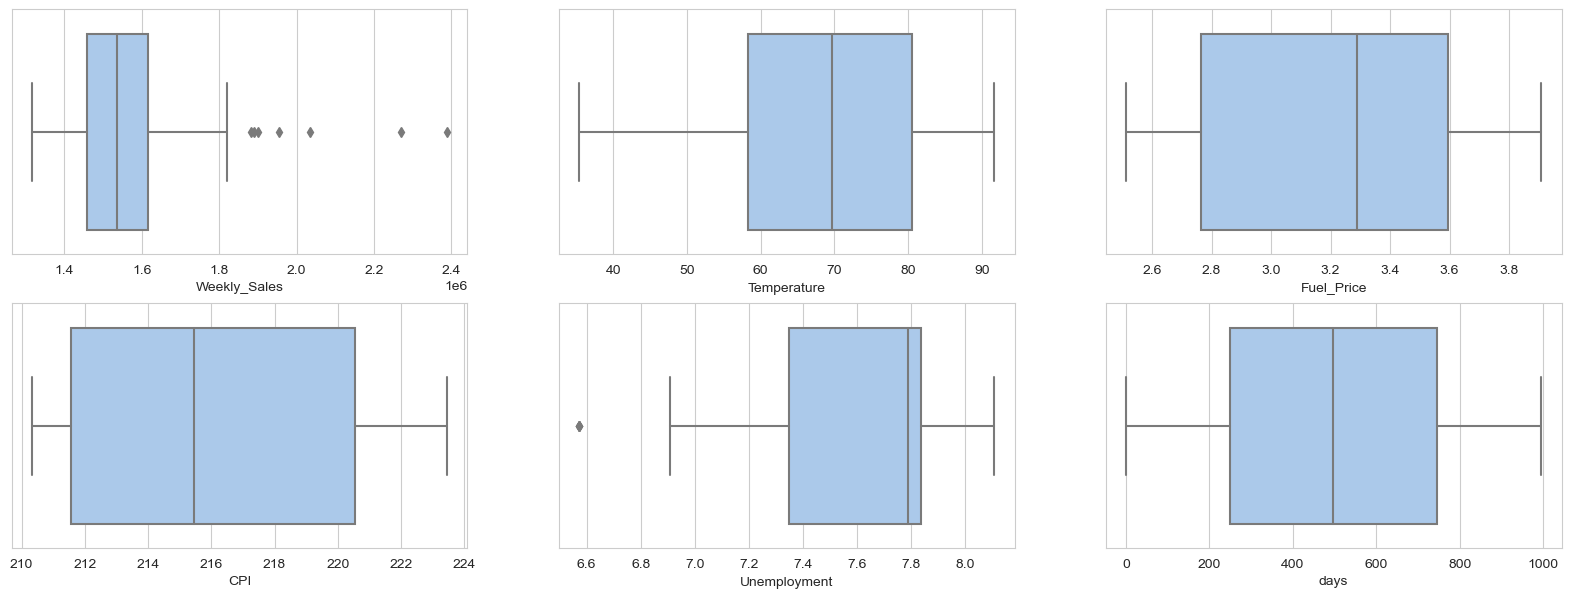

In [12]:
#converting each date to number of days since the 1st day reported on this dataset.
store1 = sales[sales['Store'] == 1].sort_values(by = 'Date', ascending = True)

def date_to_days(df):
    days = []
    for i in df:
        convert = (i - df[0]).days
        days.append(convert)
    days[0] = 1
    return days
store1['days'] = date_to_days(store1['Date'])

fig, ax = plt.subplots(2,3, figsize = (20,7))

columns = list(store1.drop(['Store','Holiday_Flag','Date'], axis = 1).columns)
for i, col in enumerate(store1[columns]):
    sns.boxplot(x = col,
                data = store1,
                palette = 'pastel',
                   ax = ax[i//3, i%3])

plt.show()

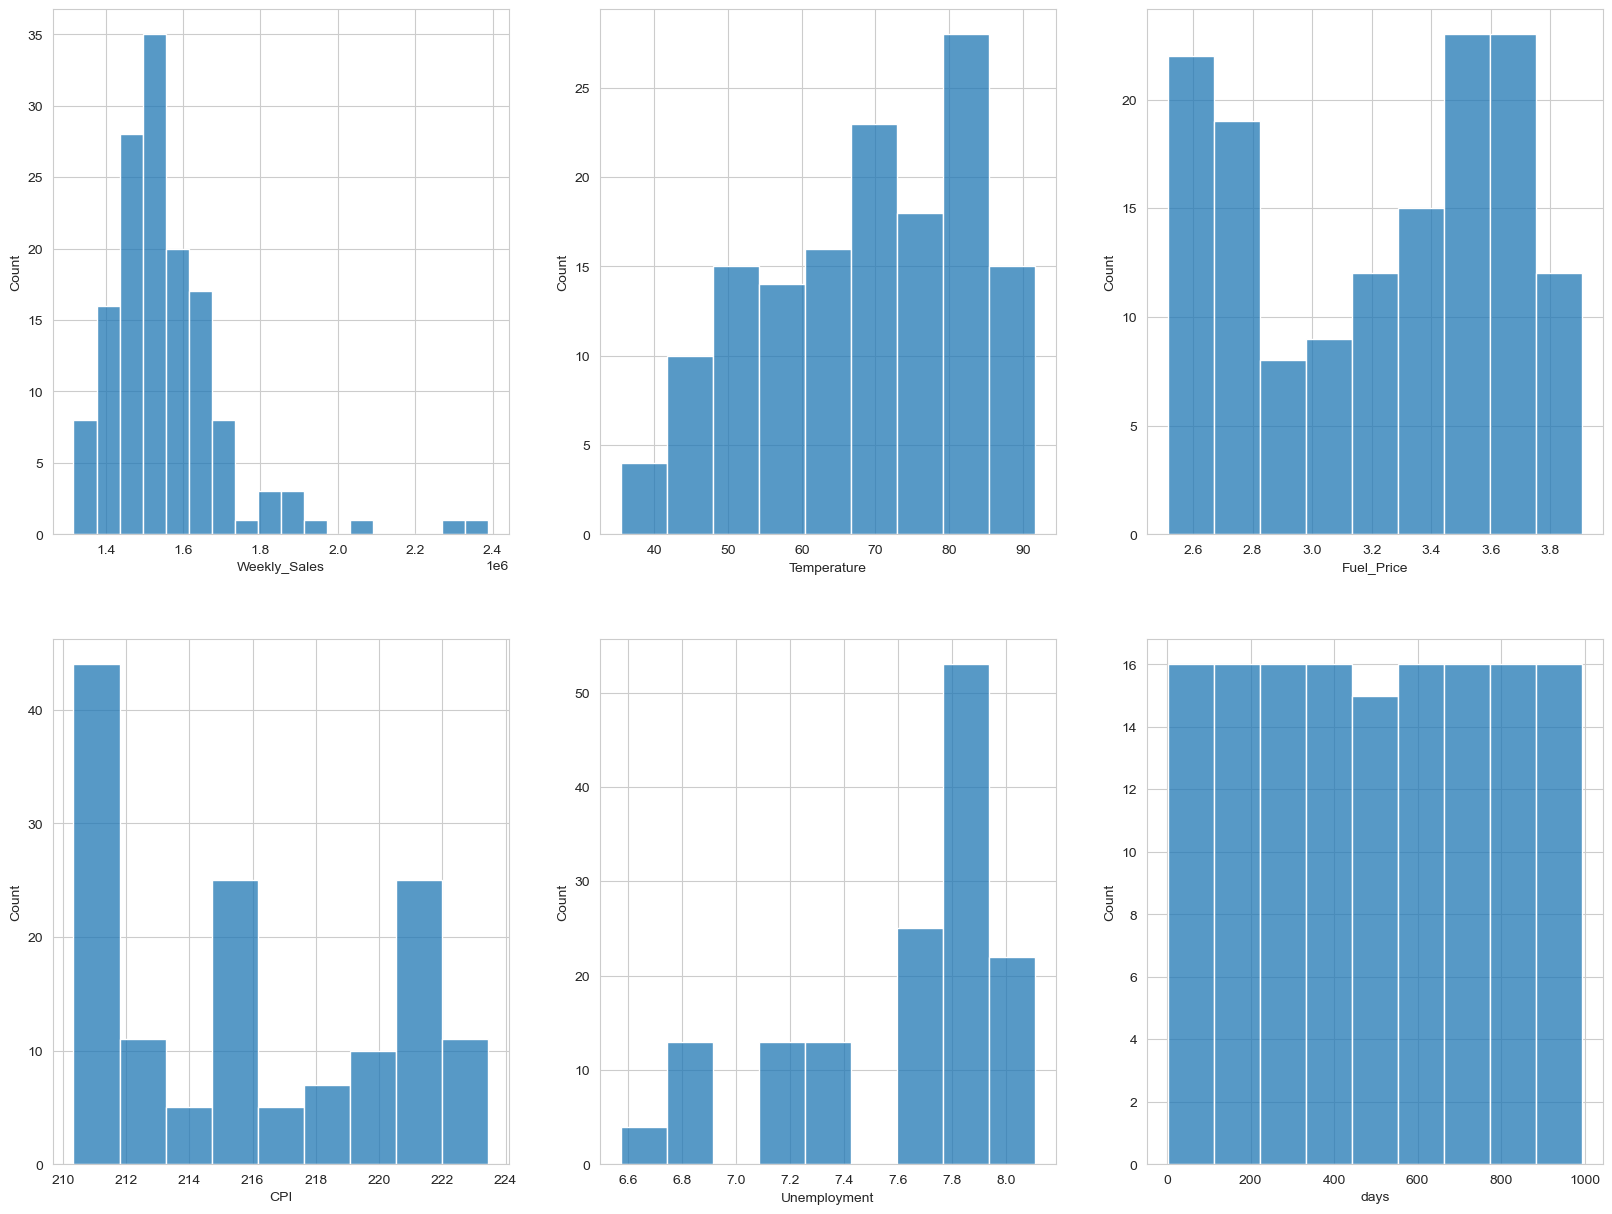

In [18]:
# Independent variables do not particularly have any outliers. However, the dependent variable Weekly_Sales has many.

fig, ax = plt.subplots(2,3, figsize = (20,15))

for i, col in enumerate(store1[columns]):
    sns.histplot(x = col,
                   data = store1,
                   ax = ax[i//3, i%3])

plt.show()

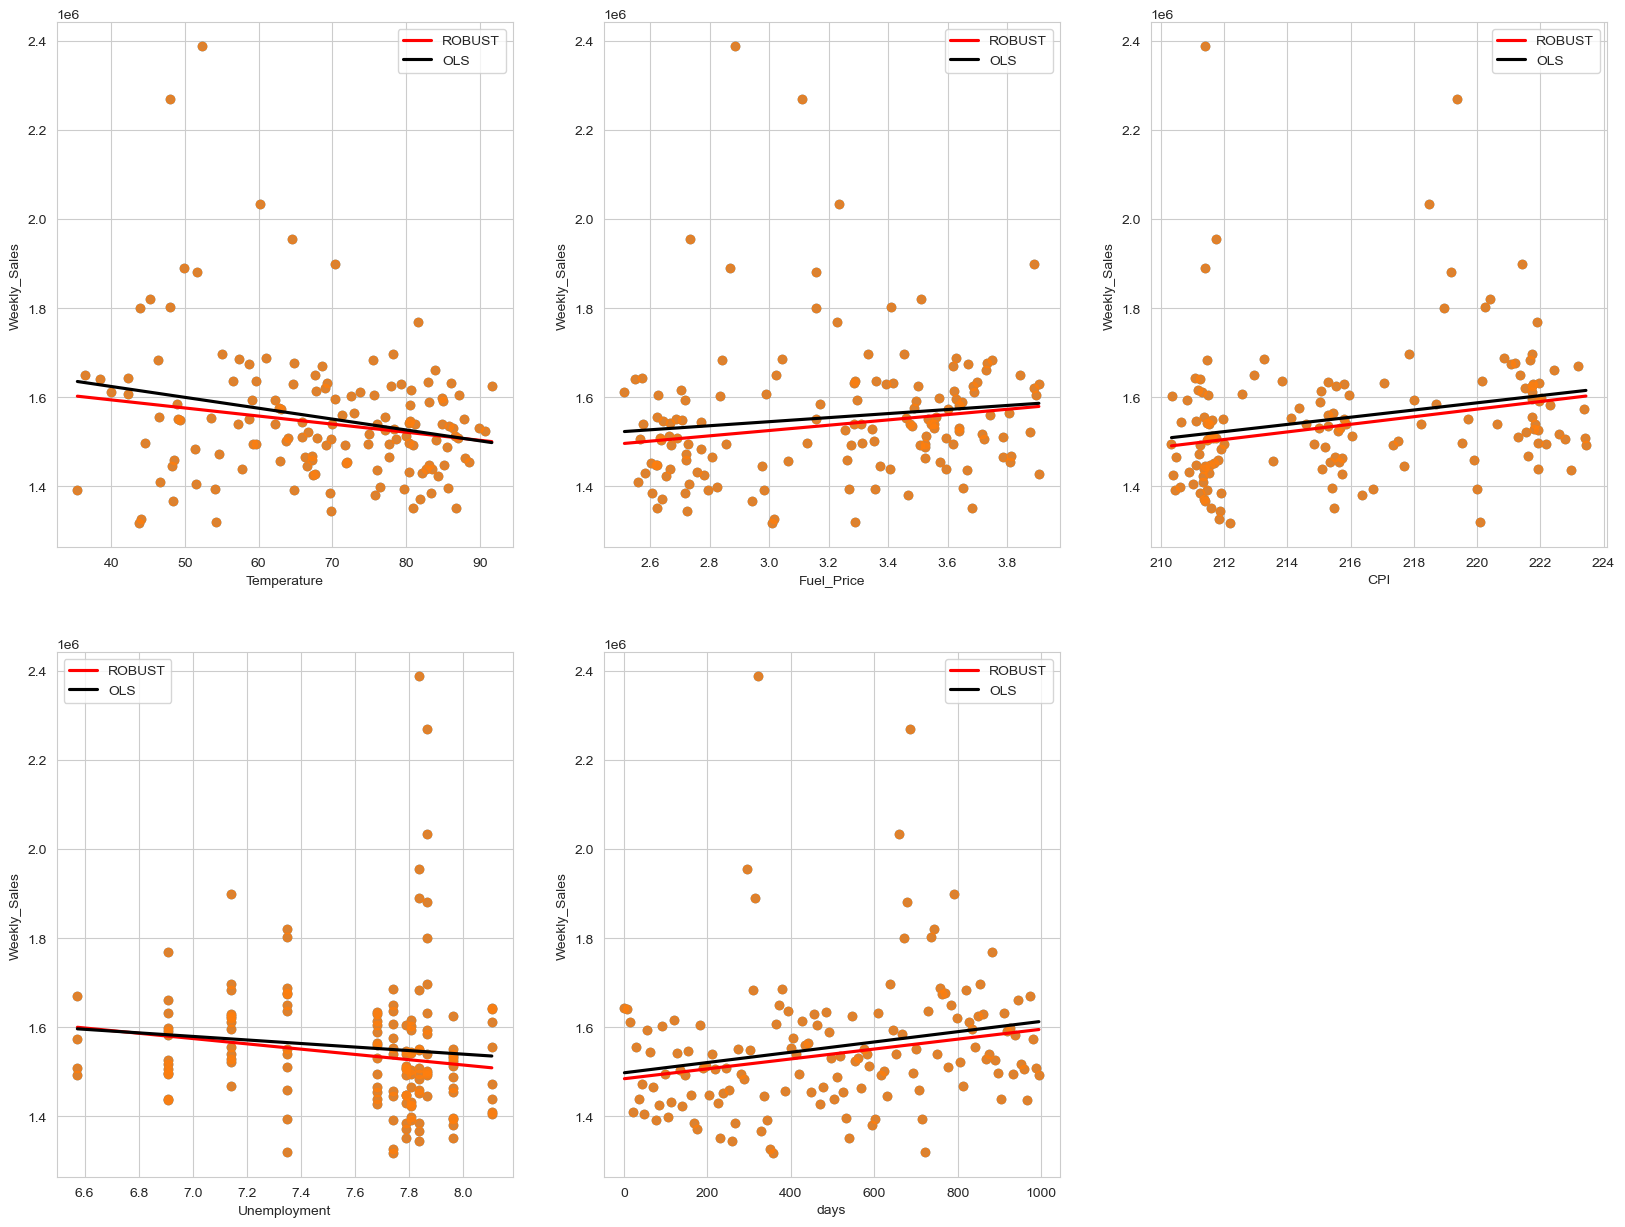

In [13]:
fig, ax = plt.subplots(2,3, figsize = (20,15))
reg_columns = columns = list(store1.drop(['Store','Weekly_Sales','Holiday_Flag','Date'], axis = 1).columns)
for i, col in enumerate(store1[reg_columns]):
    sns.regplot(x = store1[col], y = store1['Weekly_Sales'],
                ci = None,
                robust = True,
                line_kws = {'color':'red','label':'ROBUST'},
                ax = ax[i//3, i%3])
    sns.regplot(x = store1[col], y = store1['Weekly_Sales'],
                ci = None,
                line_kws = {'color':'black', 'label':'OLS'},
                ax = ax[i//3, i%3])
    ax[i//3,i%3].legend()

ax[1,2].set_visible(False)

plt.show()

# Despite the outliers in the dependent variable Weekly_Sales, the relationship with the independent variables seem to be fairly linear.OLS will be affected by the outliers so a comparison was made with robust method.

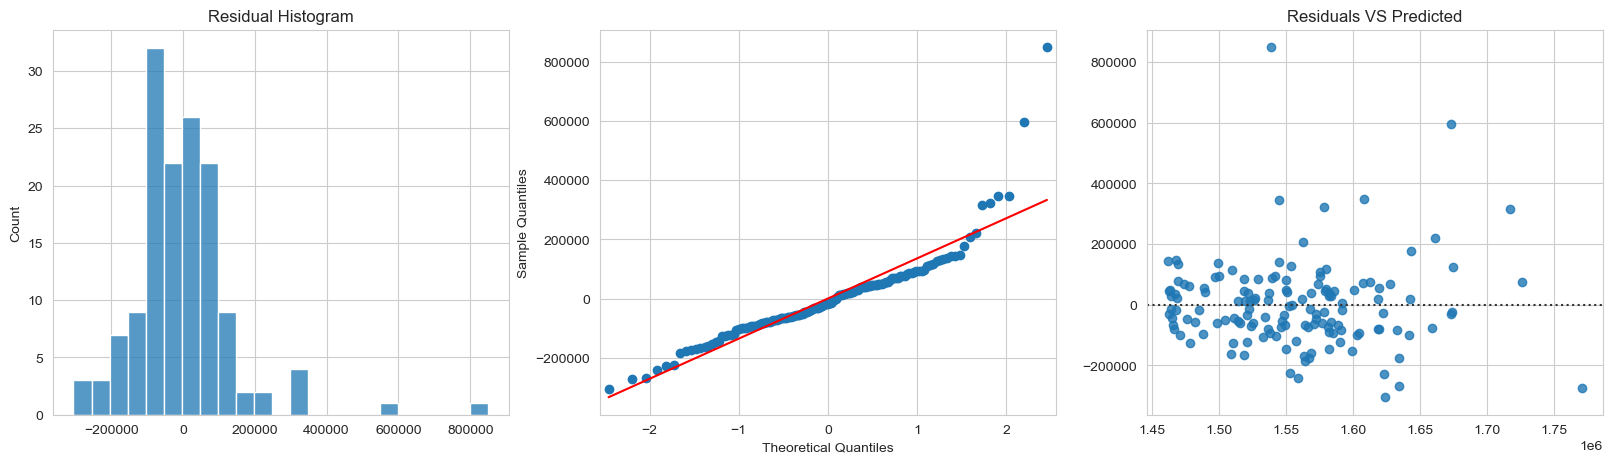

In [15]:
x = store1[store1.drop(['Weekly_Sales','Date','Store'], axis = 1).columns]
y = store1['Weekly_Sales']
x_constant = sm.add_constant(x)

lm = sm.OLS(y, x_constant).fit()

fig, ax = plt.subplots(1,3, figsize = (20,5))
sns.histplot(lm.resid, ax = ax[0]).set_title('Residual Histogram')
sm.qqplot(lm.resid,line = 'r', ax = ax[1])
sns.residplot(x=lm.fittedvalues, y=lm.resid, ax=ax[2])
ax[2].set_title('Residuals VS Predicted')
plt.show()


In [26]:
rlm_constant = x_constant.drop(['CPI','days'], axis = 1)
rlm = sm.RLM(y,rlm_constant).fit()

# Diagnostic tests on robust linear model.
dw = durbin_watson(rlm.resid)
_,jbpval,_,_ =  jarque_bera(rlm.resid)
_,hppval,_,_ = het_breuschpagan(rlm.resid, rlm.model.exog)

if dw > 1.5:
    print('No autocorrelation.')
else:
    print('Autoccorelation is present.')
if jbpval < 0.05 and round(np.mean(rlm.resid)) == 0:
    print('Residuals are not completely normal, but mean of residuals is approximately zero.')
else:
    print('Residuals are nornmal.')
if hppval < 0.05:
    print('Heteroskedasticity')
else:
    print('Homoskedasticity')

No autocorrelation.
Residuals are nornmal.
Homoskedasticity


In [27]:
rlm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:                            RLM   Df Residuals:                      138
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 28 Mar 2024                                         
Time:                        20:23:45                                         
No. Iterations:                     2                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.799e+06   2.61e+05      6.898      0.000    1.29e+06    2.31e+06
Holiday_Flag  9.557e+04   3.57e+04      2.674      0.008    2.55e+04    1.66e+05
Temperature  -2063.6544    658.160     -3.135      0.002   -3353.625    -773.684
Fuel_Price    5.732e+04   2.47e+04      2.317      0.021    8830.231    1.06e+05
Unemployment  -4.02e+04   2.73e+04     -1.474      0.141   -9.37e+04    1.33e+04
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""